In [1]:
from requests import get
from requests import codes
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
# definte functions for dowloading html page content
def log_error(e):
    print(e)

    
def simple_get(url):
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None
            
    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None

    
def is_good_response(resp):
    return resp.status_code == codes.ok

In [3]:
# collate data into dataframes
header_rows = ['Player', 'Years Active', 'Matches', 'Innings', 'Not Outs', 'Runs', 'High Score', 
               'Average', '100s', '50s', '0s']

def download_page_stats(url):
    page_stats = []
    html_page_soup = BeautifulSoup(simple_get(url), 'html.parser')
    tablerow_object_list = html_page_soup.find_all('tr',{'class':'data1'})
    for row in tablerow_object_list:
        unfiltered_row = row.get_text().split(' ' and '\n')
        filtered_row = list(filter(lambda x: x != '', unfiltered_row))
        page_stats.append(filtered_row)
    
    return page_stats
    
# loop over each page from the query of ESPN's database, and add to dataframe
for page in range(1,50):
    # home batting statistics
    try:
        home_batting_url = (r'http://stats.espncricinfo.com/ci/engine/stats/index.html?'
                            + r'class=1;home_or_away=1;orderby=batting_average;page='
                            + str(page) + r';template=results;type=batting')
        home_page_stats = download_page_stats(home_batting_url)
        home_page_df = pd.DataFrame(home_page_stats, columns=header_rows)
        if page == 1:
            home_batting_df = home_page_df
        else:
            home_batting_df = pd.concat([home_batting_df, home_page_df], axis=0, ignore_index=True)
    except:
        continue
    
    # away batting statistics
    try:
        away_batting_url = (r'http://stats.espncricinfo.com/ci/engine/stats/index.html?'
                            + r'class=1;home_or_away=2;orderby=batting_average;page='
                            + str(page) + r';template=results;type=batting')
        away_page_stats = download_page_stats(away_batting_url)
        away_page_df = pd.DataFrame(away_page_stats, columns=header_rows)
        if page == 1:
            away_batting_df = away_page_df
        else:
            away_batting_df = pd.concat([away_batting_df, away_page_df], axis=0, ignore_index=True)
    except:
        continue

In [4]:
# clean data and pull out averages
for df in [home_batting_df, away_batting_df]:    
    for idx, row in df.iterrows():
        if row['Innings'] == '-':
            df.drop(index=idx, axis=0, inplace=True)
        elif pd.to_numeric(row['Innings']) < 20:
            df.drop(index=idx, axis=0, inplace=True)
        else:
            continue
            
home_batting_df.set_index('Player', inplace=True)
away_batting_df.set_index('Player', inplace=True)

home_averages_df = home_batting_df['Average']
away_averages_df = away_batting_df['Average']

averages = pd.merge(home_averages_df, away_averages_df, how='inner', left_index=True, right_index=True)
averages.rename(columns={'Average_x': 'Home', 'Average_y': 'Away'}, inplace=True)
for column in averages:
    averages[column] = pd.to_numeric(averages[column])

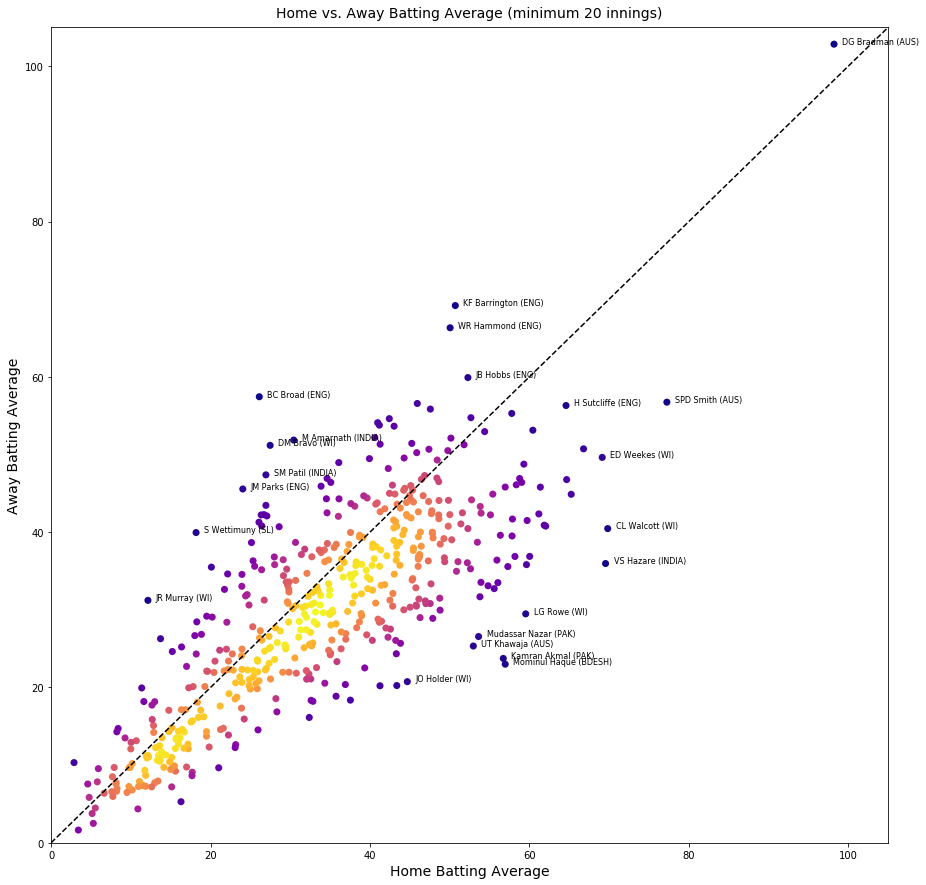

In [5]:
# plot data, using an estimate of the probability density function (guassian kde) to create a heat map
x = averages['Home']
y = averages['Away']
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
x_ref = np.linspace(0,105,105)
y_ref = x_ref

fig, ax = plt.subplots(1,1, figsize=(15,15))
ax.scatter(x, y, c=z, s=50, edgecolor='', cmap='plasma')
ax.plot(x_ref, y_ref, 'k--')
ax.set_xlim([0, 105])
ax.set_ylim([0, 105])
ax.set_ylabel('Away Batting Average', fontsize=14)
ax.set_xlabel('Home Batting Average', fontsize=14)
ax.set_title('Home vs. Away Batting Average (minimum 20 innings)', fontdict={'fontsize':14}, pad=10)
for i, player in enumerate(averages.index.values):
    if z[i] < 1e-4:
        ax.annotate(averages.index.values[i], (x[i]+1, y[i]), fontsize=8)